In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from hydranerv.model.lifneuron import LIFNeuron
from hydranerv.model.rp_pacemaker import RPPacemaker
from hydranerv.model.cb_pacemaker import CBPacemaker
from hydranerv.model.latent_variable import LatentVariable
from hydranerv.utils.utils import *

## 0. Basic tests

LIF model 
$$\tau\frac{\mathrm{d}V}{\mathrm{d}t} = -V + RI \\ I = I_{\text{light}} + I_{\theta} + I_{\text{syn}}$$

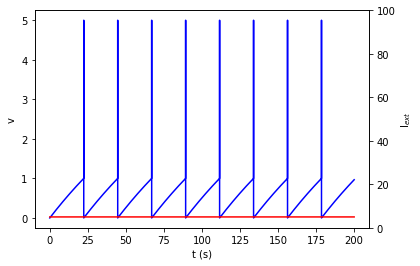

In [2]:
# Conceptual RP
rp = LIFNeuron()
T = 200000 # ms
dt = 1 # ms
i_ext_train = np.zeros(int(T/dt)+1) + 5 # environmental variable encoded by RP pacemaker
run_neuron(T=T, dt=dt, i_ext_train=i_ext_train, neuron=rp)

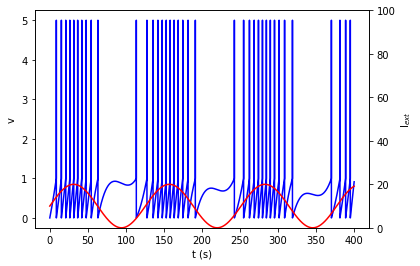

In [4]:
# Conceptual CB
cb = LIFNeuron()
T = 400000 # ms
dt = 1 # ms
x = np.linspace(0, T, int(T/dt)+1)
i_ext_train = 10*np.sin(0.00005*x) + 10 # environmental variable encoded by CB pacemaker
run_neuron(T=T, dt=dt, i_ext_train=i_ext_train, neuron=cb)

## 1. Pacemakers' responses to $\theta$ (latent variable)

For CB pacemakers:
$$I_{\theta} = \frac{I_{\text{max}}}{1 + \exp(\alpha(\theta-\theta_{\text{th}}))}$$

For RP pacemakers:
$$I_{\theta} = \theta$$

For $\theta$:
$$\frac{\mathrm{d}\theta}{\mathrm{d}t} = -r_{\text{dec}} \theta + r_{\text{inc}} \sum_{t_{\text{spike}}}\left(H\left(t-t_{\text{spike}}-\Delta_{\text{retard}}\right) - H\left(t-t_{\text{spike}}\right)\right) $$

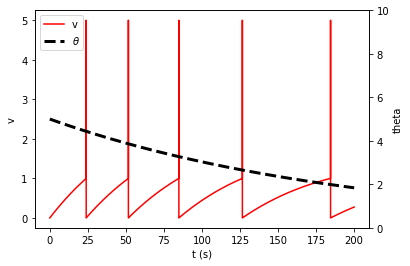

In [5]:
# RP to theta
T = 200000
dt = 1
rp_pacemaker = RPPacemaker()
var_lat = LatentVariable()

time = np.arange(0, T + dt, dt)
for j, t in enumerate(time):
    theta = var_lat.step(t)
    rp_pacemaker.step(t, theta, 0, 0)

fig = plt.figure()
ax1 = fig.add_subplot(111)
lns1 = ax1.plot(time / 1000, rp_pacemaker.v_train, 'r', label='v')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('v')
ax2 = ax1.twinx()
lns2 = ax2.plot(time / 1000, var_lat.theta_train, 'k--', linewidth=3, label=r'$\theta$')
ax2.set_ylabel('theta')
ax2.set_ylim(0, 10)
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')
plt.show()

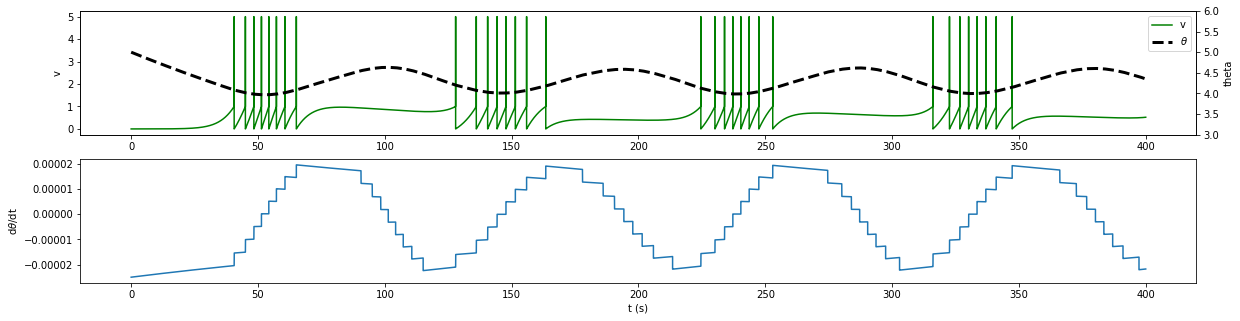

In [8]:
# CB to theta
T = 400000
dt = 1
cb_pacemaker = CBPacemaker()
var_lat = LatentVariable()

time = np.arange(0, T + dt, dt)
for j, t in enumerate(time):
    if j > 0:
        cb_fired = cb_pacemaker.spike_train[-1]
    else:
        cb_fired = False
    theta = var_lat.step(t, cb_fired)
    cb_pacemaker.step(t, theta, 0, 0)

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
lns1 = ax1.plot(time / 1000, cb_pacemaker.v_train, 'g', label='v')
ax1.set_ylabel('v')
ax2 = ax1.twinx()
lns2 = ax2.plot(time / 1000, var_lat.theta_train, 'k--', linewidth=3, label=r'$\theta$')
ax2.set_ylabel('theta')
ax2.set_ylim(3, 6)
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')
ax3 = fig.add_subplot(212)
ax3.plot(time / 1000, var_lat.deriv_train)
ax3.set_xlabel('t (s)')
ax3.set_ylabel(r'd$\theta$/dt')
plt.show()

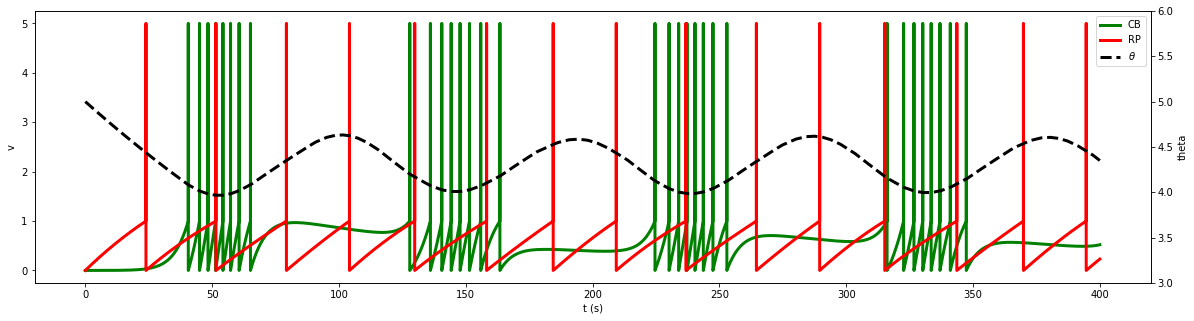

In [9]:
# Put together
T = 400000
dt = 1
rp_pacemaker = RPPacemaker()
cb_pacemaker = CBPacemaker()
var_lat = LatentVariable()

time = np.arange(0, T + dt, dt)
for j, t in enumerate(time):
    cb_fired = cb_pacemaker.spike_train[-1] if j > 0 else False
    theta = var_lat.step(t, cb_fired)
    cb_pacemaker.step(t, theta, 0, 0)
    rp_pacemaker.step(t, theta, 0, 0)

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(111)
lns1 = ax1.plot(time / 1000, cb_pacemaker.v_train, 'g', linewidth=3, label='CB')
lns2 = ax1.plot(time / 1000, rp_pacemaker.v_train, 'r', linewidth=3, label='RP')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('v')
ax2 = ax1.twinx()
lns3 = ax2.plot(time / 1000, var_lat.theta_train, 'k--', linewidth=3, label=r'$\theta$')
ax2.set_ylabel('theta')
ax2.set_ylim(3, 6)
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')
plt.show()

## 2. Pacemakers' response to light

For CB pacemakers:
- $I_{\text{light}} = -\beta\times\text{light}\times V$

or

- $R \sim 1/{\text{light}}$

For RP pacemakers:
- $I_{\text{light}} = \text{light}$

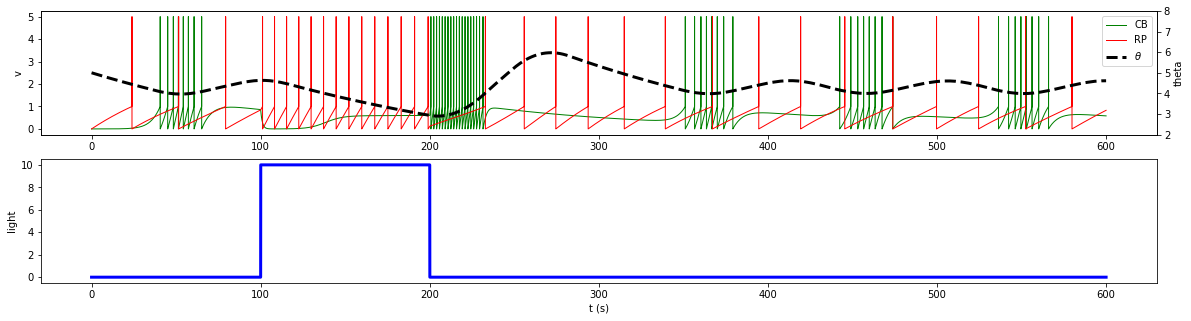

In [12]:
T = 600000
dt = 1

light = np.zeros(int(T/dt)+1)
light[int(100000/dt) : int(200000/dt)] = 10

rp_pacemaker = RPPacemaker()
cb_pacemaker = CBPacemaker()
var_lat = LatentVariable()

time = np.arange(0, T + dt, dt)
for j, t in enumerate(time):
    cb_fired = cb_pacemaker.spike_train[-1] if j > 0 else False
    theta = var_lat.step(t, cb_fired)
    cb_pacemaker.step(t, theta, light[j], 0)
    rp_pacemaker.step(t, theta, light[j], 0)

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(211)
lns1 = ax1.plot(time / 1000, cb_pacemaker.v_train, 'g', linewidth=1, label='CB')
lns2 = ax1.plot(time / 1000, rp_pacemaker.v_train, 'r', linewidth=1, label='RP')
ax1.set_ylabel('v')
ax2 = ax1.twinx()
lns3 = ax2.plot(time / 1000, var_lat.theta_train, 'k--', linewidth=3, label=r'$\theta$')
ax2.set_ylabel('theta')
ax2.set_ylim(2, 8)
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')
ax3 = fig.add_subplot(212)
ax3.plot(time / 1000, light, 'b', linewidth=3)
ax3.set_ylabel('light')
ax3.set_xlabel('t (s)')
plt.show()